#### Quá trình mùa: Dữ liệu doanh số đồ uống tại Mỹ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

In [3]:
# Tải dữ liệu
sales = pd.read_excel('../Data/Retail Sales.xls').set_index('Year')
sales.head()

,Q1,Q2,Q3,Q4
Year,,,,
1992,4647,5272,5544,6224
1993,4821,5301,5434,5982
1994,4767,5444,5662,6228
1995,4781,5369,5592,6265
1996,5168,5713,5877,6399


In [4]:
# Định dạng lại dữ liệu
Quarter = pd.period_range(start='1992Q1', end='2019Q4', freq='Q')
Sales = sales.to_numpy().flatten()
data = pd.DataFrame({'Quarter': Quarter, 'Sales': Sales}).set_index('Quarter')
data.head()

,Sales
Quarter,
1992Q1,4647
1992Q2,5272
1992Q3,5544
1992Q4,6224
1993Q1,4821


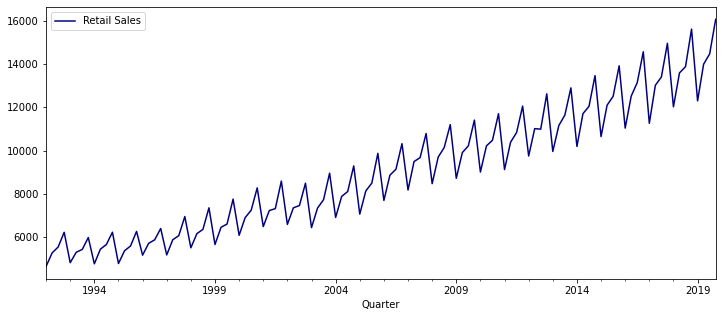

In [5]:
# Vẽ biểu đồ
plt.subplots(figsize=(12,5))
data.Sales.plot(color="navy", label = "Retail Sales")
plt.legend()

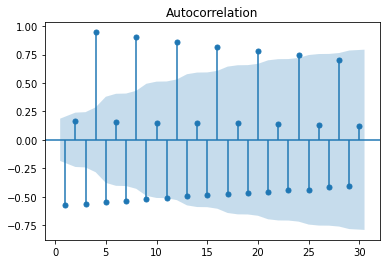

In [6]:
# Biểu đồ hàm ACF của dữ liệu sai phân
data_diff = data.diff().dropna()
fig = plot_acf(data_diff, lags = 30, zero = False)

#### Mô hình hoá thành phần mùa tất định

In [7]:
from statsmodels.tsa.deterministic import DeterministicProcess

# Thành phần mùa tất định
det_proc = DeterministicProcess(data.index, constant=False, seasonal=True)
det_terms = det_proc.in_sample()
det_terms.head()

,"s(1,4)","s(2,4)","s(3,4)","s(4,4)"
Quarter,,,,
1992Q1,1.0,0.0,0.0,0.0
1992Q2,0.0,1.0,0.0,0.0
1992Q3,0.0,0.0,1.0,0.0
1992Q4,0.0,0.0,0.0,1.0
1993Q1,1.0,0.0,0.0,0.0


In [8]:
# Ước lượng mô hình mùa tất định có xu thế
model = ARIMA(data.Sales, order=(0,0,0), trend="t", exog=det_terms)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  112
Model:                          ARIMA   Log Likelihood                -840.737
Date:                Thu, 14 Dec 2023   AIC                           1693.475
Time:                        23:21:19   BIC                           1709.786
Sample:                    03-31-1992   HQIC                          1700.092
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         84.2670      1.124     74.985      0.000      82.064      86.470
s(1,4)      3167.0462     93.669     33.811      0.000    2983.459    3350.633
s(2,4)      4140.2795    113.151     36.591      0.000    3918.507    4362.052
s(3,4)      4340.2943    113.581     38.213      0.000    4117.680    4562.909
s(4,4)      5404.2461    122.043     44.282      0.000    5165.047    5643.445
sigma2      1.939e+05   2.94e+04      6.607      0.000    1.36e+05    2.51e+05
===================================================================================
Ljung-Box (L1) (Q):                  30.97   Jarque-Bera (JB):                21.58
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             1.01
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

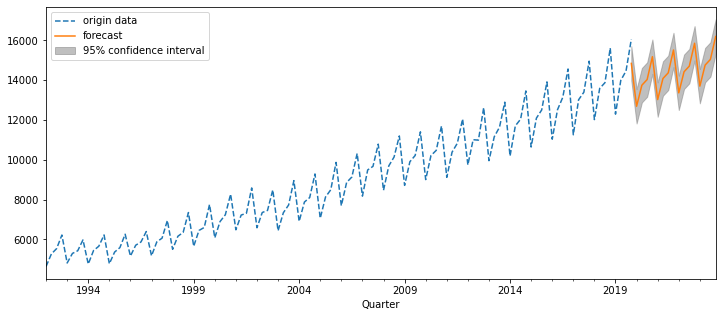

In [9]:
# Dự báo thành phần mùa tất định
det_terms_pred = det_proc.out_of_sample(16)

# Đồ thị giá trị dự báo
fig, ax = plt.subplots(figsize=(12,5))
data.Sales.plot(linestyle='--', label = 'origin data')
fig = plot_predict(result, start = len(data)-1,end = len(data)+15, 
                   exog=det_terms_pred, ax=ax)

#### Mô hình hoá thành phần mùa ngẫu nhiên

In [10]:
# Lấy sai phân mùa + sai phân chuỗi doanh số bán lẻ
data_ds = data.diff(periods = 4).diff().dropna()
data_ds.head()

,Sales
Quarter,
1993Q2,-145.0
1993Q3,-139.0
1993Q4,-132.0
1994Q1,188.0
1994Q2,197.0


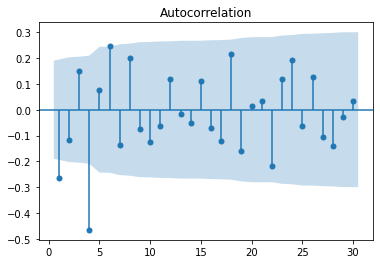

In [11]:
# Biểu đồ hàm ACF của dữ liệu sai phân mùa
fig = plot_acf(data_ds, lags = 30, zero = False)

In [12]:
# Ước lượng mô hình ARIMA mùa
model = ARIMA(data.Sales, order=(0,1,1), seasonal_order=(0,1,1,4))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                           Sales   No. Observations:                  112
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                -692.432
Date:                         Thu, 14 Dec 2023   AIC                           1390.863
Time:                                 23:21:20   BIC                           1398.882
Sample:                             03-31-1992   HQIC                          1394.114
                                  - 12-31-2019                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4416      0.095     -4.651      0.000      -0.628      -0.256
ma.S.L4       -0.3960      0.084     -4.689      0.000      -0.562      -0.230
sigma2      2.411e+04   3889.303      6.198      0.000    1.65e+04    3.17e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 1.09
Prob(Q):                              0.66   Prob(JB):                         0.58
Heteroskedasticity (H):               1.25   Skew:                            -0.10
Prob(H) (two-sided):                  0.50   Kurtosis:                         2.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

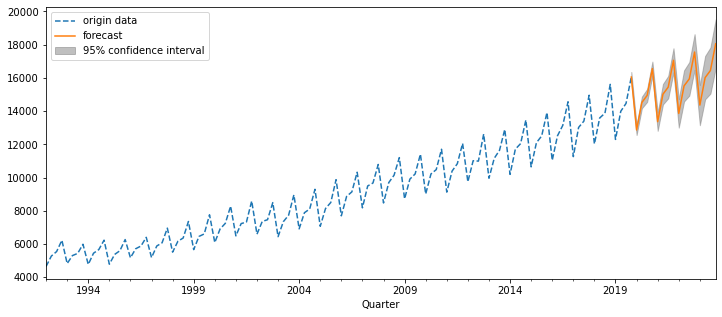

In [13]:
# Dự báo doanh số đồ uống
fig, ax = plt.subplots(figsize=(12,5))
data.Sales.plot(linestyle='--', label = 'origin data')
fig = plot_predict(result, len(data.Sales)-1, len(data.Sales)+15, ax=ax)